In [84]:
#@title libraries
import os
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import re
import tensorflow
import gensim
from gensim.models import Word2Vec, word2vec
from tqdm import tqdm
import multiprocessing
try: 
  import contractions
except: 
  !pip install contractions
  import contractions
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB 

from sklearn import svm
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor    

from keras.utils import np_utils
from keras.preprocessing import sequence, text
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import BatchNormalization
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.callbacks import EarlyStopping

import plotly.graph_objects as go
import plotly.offline as pyo

import matplotlib.cm as cm
from sklearn.manifold import TSNE

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


#Import Data

In [85]:
df = pd.read_csv("Tweets.csv")
df = df[['airline_sentiment', 'airline', 'text', 'negativereason']]
df

,airline_sentiment,airline,text,negativereason
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.,NaN
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...,NaN
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...,NaN
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...,Bad Flight
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing...,Can't Tell
...,...,...,...,...
14635,positive,American,@AmericanAir thank you we got on a different f...,NaN
14636,negative,American,@AmericanAir leaving over 20 minutes Late Flig...,Customer Service Issue
14637,neutral,American,@AmericanAir Please bring American Airlines to...,NaN
14638,negative,American,"@AmericanAir you have my money, you change my ...",Customer Service Issue


In [86]:
df.describe()

,airline_sentiment,airline,text,negativereason
count,14640,14640,14640,9178
unique,3,6,14427,10
top,negative,United,@united thanks,Customer Service Issue
freq,9178,3822,6,2910


In [87]:
df.isna().sum() #negative reasons are only available to negative classified tweets

airline_sentiment       0
airline                 0
text                    0
negativereason       5462
dtype: int64

#exploratory data analysis

Number of tweets:  14640


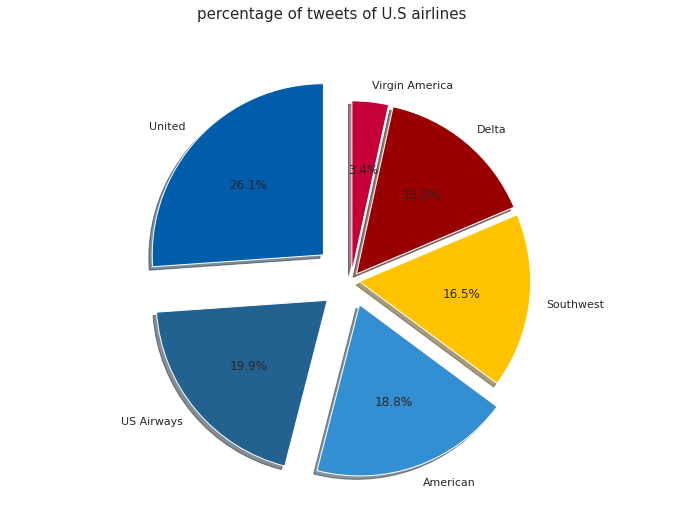

In [88]:
#pie char for proportion of tweets that each airline hold 
airline_distribution = df.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False)
print("Number of tweets: ",len(df))

labels = airline_distribution.index
sizes = airline_distribution.tolist()
explode = (0.22, 0.18, 0.15, 0.05, 0.05, 0.05)
colors = ( "#005DAA", "#226190", "#348FD2", "#FFC300", "#990000", "#C70039")

fig, ax = plt.subplots()
fig.suptitle('percentage of tweets of U.S airlines', fontsize=15)
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', colors=colors, shadow=True, startangle=90)
ax.axis('equal')  
plt.show()

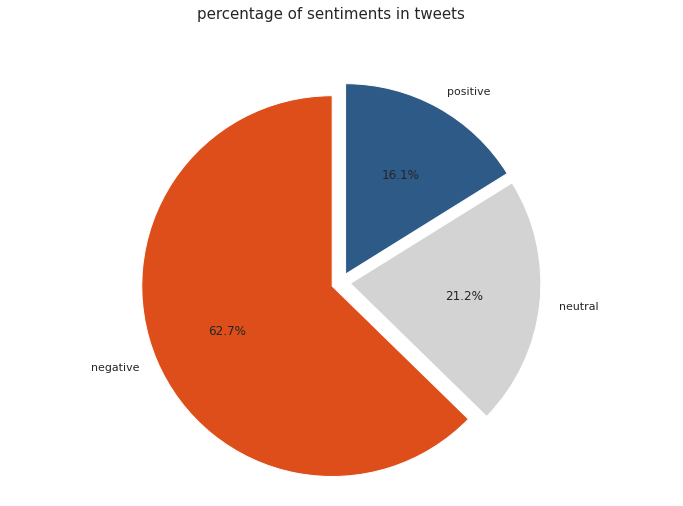

In [89]:
#pie chart for distribution of sentiments in tweets
sentiment_distribution = df.groupby('airline_sentiment')['airline'].count()
labels = sentiment_distribution.index
sizes = sentiment_distribution.tolist()
colors = ['#DD4E1A', 'lightgray', '#2E5A88']
fig, ax = plt.subplots()
explode = (0.05,0.05,0.05)
fig.suptitle('percentage of sentiments in tweets', fontsize=15)
ax.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%', colors=colors, shadow=False, startangle=90)
ax.axis('equal')  
plt.show()

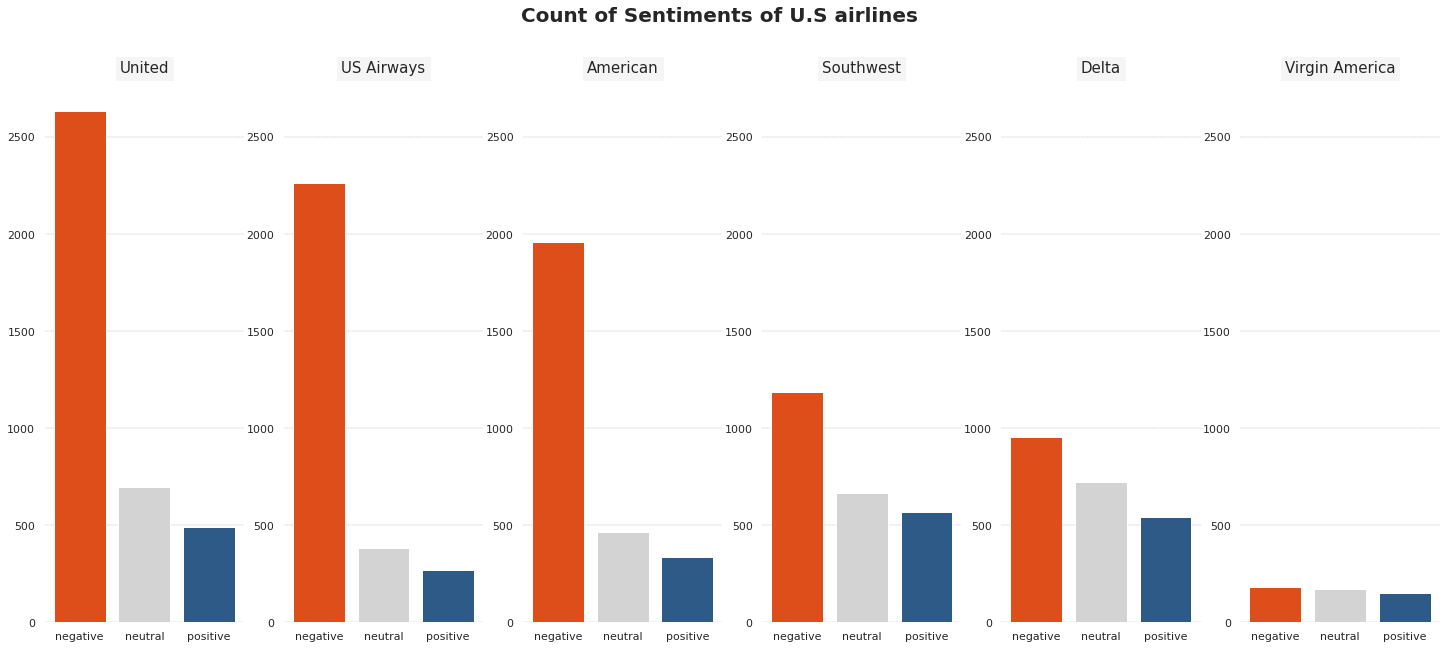

In [90]:
#Bar charts showing the count of sentiments of each airline 
airlines= ['United','US Airways','American','Southwest','Delta','Virgin America']
fig = plt.figure(1, figsize=(25,10))
fig.suptitle('Count of Sentiments of U.S airlines', fontsize=20, fontweight='bold')
i = 1
for airline in airlines: 
  plt.subplot(1,6,i)
  airline_df = df[df['airline']==airline]
  ratings = airline_df['airline_sentiment'].value_counts()
  index = range(len(set(df['airline_sentiment'])))
  plt.bar(index, ratings, color=['#DD4E1A', 'lightgray', '#2E5A88'])
  plt.gca().yaxis.grid(True, color = "grey", linewidth = "0.3", linestyle = "dashed")
  plt.xticks(index,['negative','neutral','positive'])
  plt.ylim(0, 2800)
  plt.title(airline,  fontsize='15', backgroundcolor='#F5F5F5')
  plt.box(False)
  i += 1

#Negative reason: plotly

In [91]:
#radar plot for negative reason distribution for each airline 
airline_names = ['United', 'US Airways','American', 'Southwest', 'Delta', 'Virgin America']
categories = ['Customer Service Issue','Late Flight', "Can't Tell", 'Bad Flight', 'Lost Luggage', 'Cancelled Flight', 'Flight Booking Problems', 'Flight Attendant Complaints', 'longlines', 'Damaged Luggage']
count_neg_dict = {}
for airline in airline_names: 
  count_neg_reasons = df['negativereason'][df['airline']== airline].value_counts()[categories]
  count_neg_dict[airline] = count_neg_reasons.tolist()
print(count_neg_dict)

fig = go.Figure(
    data=[
          go.Scatterpolar(r=count_neg_dict[airline], theta=categories, fill='toself', name=airline) for airline in airline_names], 
    layout = go.Layout(
        title=go.layout.Title(text='Reasons for negative tweet'), 
        polar = {'radialaxis': {'visible': True}}, 
        showlegend=True
    )
)
pyo.plot(fig)
#plot found in html file

{'United': [681, 525, 379, 216, 269, 181, 144, 168, 48, 22], 'US Airways': [811, 453, 246, 104, 154, 189, 122, 123, 50, 11], 'American': [768, 249, 198, 87, 149, 246, 130, 87, 34, 12], 'Southwest': [391, 152, 159, 90, 90, 162, 61, 38, 29, 14], 'Delta': [199, 269, 186, 64, 57, 51, 44, 60, 14, 11], 'Virgin America': [60, 17, 22, 19, 5, 18, 28, 5, 3, 4]}


'temp-plot.html'

#Create data (excel) for Word Cloud

In [92]:
stop_words = set(stopwords.words("english"))
stop_words.update(('get', 'amp', 'us', 'co', 'http', 'one', 'would', 'got', 'dm'))
airline_tuple = ('virginamerica', 'americanair','united', 'southwestair', 'jetblue','usairways')
stop_words.update(airline_tuple)
# stemmer = SnowballStemmer("english")

def tokenize_tweet(text): 
  text = re.sub("[^a-zA-Z]", " ", text).lower()
  text = contractions.fix(text)
  tokens = nltk.word_tokenize(text)
  tokens = [t for t in tokens if t not in stop_words]
  # tokens = [stemmer.stem(t) for t in tokens]
  return ", ".join(tokens)

df['wordcloud_text'] = df['text'].apply(lambda x: tokenize_tweet(x))

In [93]:
neg_df = df[['airline_sentiment', 'wordcloud_text']][df['airline_sentiment'] == 'negative']
neut_df = df[['airline_sentiment', 'wordcloud_text']][df['airline_sentiment'] == 'neutral']
pos_df = df[['airline_sentiment', 'wordcloud_text']][df['airline_sentiment'] == 'positive']
neg_words = neg_df['wordcloud_text'].str.replace(",","").str.split(expand=True).stack().value_counts()[:20]
neut_words = neut_df['wordcloud_text'].str.replace(",","").str.split(expand=True).stack().value_counts()[:10]
pos_words = pos_df['wordcloud_text'].str.replace(",","").str.split(expand=True).stack().value_counts()[:20]

neg_df = pd.DataFrame(neg_words, index = neg_words.index).reset_index()
neg_df[0] = neg_df[0] / neg_df[0].sum() * 100
neg_df['sentiment'] = -1
neut_df = pd.DataFrame(neut_words, index = neut_words.index).reset_index()
neut_df[0] = neut_df[0] / neut_df[0].sum() * 100
neut_df['sentiment'] = 0
pos_df = pd.DataFrame(pos_words, index = pos_words.index).reset_index()
pos_df[0] = pos_df[0] / pos_df[0].sum() * 100
pos_df['sentiment'] = 1

sentiment_df = neg_df.append(neut_df).append(pos_df)
sentiment_df.rename(columns={'index': "word", 0: "count"}, inplace=True)
sentiment_df.to_excel("WordCloud.xlsx")  
sentiment_df.head()

,word,count,sentiment
0,flight,22.731812,-1
1,cancelled,7.113774,-1
2,service,5.761696,-1
3,hours,5.062610,-1
4,help,4.755320,-1


#Pre-process

In [94]:
stop_words = set(stopwords.words("english"))

def tokenize_tweet(text): #string to tokens 
  text = re.sub("[^a-zA-Z]", " ", text).lower()
  text = contractions.fix(text)
  tokens = nltk.word_tokenize(text)
  tokens = [t for t in tokens if t not in stop_words]
  return ", ".join(tokens)

df['clean_text'] = df['text'].apply(lambda x: tokenize_tweet(x))
df.head(10)

,airline_sentiment,airline,text,negativereason,wordcloud_text,clean_text
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.,NaN,"dhepburn, said","virginamerica, dhepburn, said"
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...,NaN,"plus, added, commercials, experience, tacky","virginamerica, plus, added, commercials, exper..."
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...,NaN,"today, must, mean, need, take, another, trip","virginamerica, today, must, mean, need, take, ..."
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...,Bad Flight,"really, aggressive, blast, obnoxious, entertai...","virginamerica, really, aggressive, blast, obno..."
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing...,Can't Tell,"really, big, bad, thing","virginamerica, really, big, bad, thing"
5,negative,Virgin America,@VirginAmerica seriously would pay $30 a fligh...,Can't Tell,"seriously, pay, flight, seats, playing, really...","virginamerica, seriously, would, pay, flight, ..."
6,positive,Virgin America,"@VirginAmerica yes, nearly every time I fly VX...",NaN,"yes, nearly, every, time, fly, vx, ear, worm, ...","virginamerica, yes, nearly, every, time, fly, ..."
7,neutral,Virgin America,@VirginAmerica Really missed a prime opportuni...,NaN,"really, missed, prime, opportunity, men, witho...","virginamerica, really, missed, prime, opportun..."
8,positive,Virgin America,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,well,"virginamerica, well"
9,positive,Virgin America,"@VirginAmerica it was amazing, and arrived an ...",NaN,"amazing, arrived, hour, early, good","virginamerica, amazing, arrived, hour, early, ..."


In [95]:
#target value to integer ==> 0: negative 0: neutral 1: Positive
df['airline_sentiment'] = df['airline_sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
y = df['airline_sentiment']
X = df['clean_text']
#train and test split 
x_train, x_test, y_train, y_test = train_test_split(X, y,stratify=y, random_state=42, test_size=0.2, shuffle=True) #stratify solves imbalance in the data 
print(x_train.shape, x_test.shape)

(11712,) (2928,)


In [96]:
def countVec(x_train, x_test): #countVectorizer
  ctv = CountVectorizer(analyzer='word')
  ctv.fit(list(x_train) + list(x_test))
  x_train_ctv =  ctv.transform(x_train) 
  x_test_ctv = ctv.transform(x_test)
  return x_train_ctv, x_test_ctv, ctv

def tfidVec(x_train, x_test): #tfidVectorizer
  # tfv = TfidfVectorizer(analyzer='word', min_df=3, strip_accents='unicode', 
  #           ngram_range=(1, 2), use_idf=1, smooth_idf=1, sublinear_tf=1)
  tfv = TfidfVectorizer(analyzer='word', use_idf=True)
  tfv.fit(list(x_train) + list(x_test))
  x_train_tfv =  tfv.transform(x_train) 
  x_test_tfv = tfv.transform(x_test)
  return x_train_tfv, x_test_tfv, tfv

def model_evaluate(model, x, y): #returns accuracy score
  score = model.score(x, y)
  print("test_accuracy: ",model.score(x, y))
  return score

def plot_cfmatrix(model, x, y): #confusion matrix 
  ypred = model.predict(x)
  # print(classification_report(y, ypred))
  cf_matrix = confusion_matrix(y, ypred)
  categories = ['Negative', 'Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  plt.figure(figsize=(5,5))
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

def validation(model, x_train):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state = 0)
    score = cross_val_score(model, x_train, y_train, cv = skf)
    score_mean = score.mean()
    return score_mean 

from sklearn.model_selection import GridSearchCV

def grid_search(model, parameters, X_train, Y_train): #finding the best hyper-parameters
  grid = GridSearchCV(estimator=model,
                       param_grid = parameters,
                       cv = 2, verbose=2, scoring='roc_auc')
  #Fitting the grid 
  grid.fit(X_train,Y_train)
  optimal_model = grid.best_estimator_ #  model with the best parameters
  print('Best parameters are: ')
  print( grid.best_params_)
  return optimal_model

In [97]:
prediction = dict() #array with target value is added to prediction list (ypred)
accuracy = dict() #accuracy value of each model is added 

#countvectorized training and test set 
xtrain_ctv, xtest_ctv, ctv = countVec(x_train, x_test)
#vectorized training and test set 
xtrain_tfv, xtest_tfv, tfv = tfidVec(x_train, x_test)

##Logistic Regression (optimal)

In [98]:
log_params = {'C': [0.1, 1], 'solver': ['lbfgs', 'liblinear']}
log_optimal = grid_search(LogisticRegression(), log_params, xtrain_ctv, y_train)

# log_optimal with count vectorizer
prediction['Logistic_CNT'] = log_optimal.predict(xtest_ctv)
print("optimal_log accuracy: ", validation(log_optimal, xtrain_ctv))
accuracy['Logistic_CNT'] = (model_evaluate(log_optimal, xtest_ctv, y_test))

log_optimal = grid_search(LogisticRegression(), log_params, xtrain_ctv, y_train)

# log_optimal with TFIDF vectorizer
prediction['Logistic_TFIDF'] = log_optimal.predict(xtest_tfv)
print("optimal_log accuracy: ", validation(log_optimal, xtrain_tfv))
accuracy['Logistic_TFIDF'] = (model_evaluate(log_optimal, xtest_tfv, y_test))

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] END ................................C=0.1, solver=lbfgs; total time=   0.1s
[CV] END ................................C=0.1, solver=lbfgs; total time=   0.1s
[CV] END ............................C=0.1, solver=liblinear; total time=   0.1s
[CV] END ............................C=0.1, solver=liblinear; total time=   0.1s
[CV] END ..................................C=1, solver=lbfgs; total time=   0.4s
[CV] END ..................................C=1, solver=lbfgs; total time=   0.3s
[CV] END ..............................C=1, solver=liblinear; total time=   0.1s
[CV] END ..............................C=1, solver=liblinear; total time=   0.1s
Best parameters are: 
{'C': 1, 'solver': 'lbfgs'}
optimal_log accuracy:  0.9106896535385488
test_accuracy:  0.912568306010929
Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] END ................................C=0.1, solver=lbfgs; total time=   0.1s
[CV] END ..................

## Naive Bayes 

In [99]:
clf = MultinomialNB() 
clf.fit(xtrain_ctv, y_train) #count vectorizer
prediction['Naive Bayes_CNT'] = clf.predict(xtest_ctv)
print("Naive Bayes train accuracy: ", validation(clf, xtrain_ctv))
accuracy['Naive Bayes_CNT'] = model_evaluate(clf, xtest_ctv, y_test)

clf = MultinomialNB()
clf.fit(xtrain_tfv, y_train) #tfIDF
prediction['Naive Bayes_TFIDF'] = clf.predict(xtest_tfv)
print("Naive Bayes train accuracy: ", validation(clf, xtrain_tfv))
accuracy['Naive Bayes_TFIDF'] = model_evaluate(clf, xtest_tfv, y_test)

Naive Bayes train accuracy:  0.8695366360104575
test_accuracy:  0.8828551912568307
Naive Bayes train accuracy:  0.84315228638607
test_accuracy:  0.8463114754098361


## SVM (Optimal)

In [100]:
svm_parameters ={
    "C":[0.1,1], 
    "kernel":['linear', 'rbf'], 
    "gamma":['scale', 'auto'] 
}

#count vectorizer
svm_optimal = grid_search(svm.SVC(probability=True), svm_parameters, xtrain_ctv, y_train)
prediction['SVM_CNT'] = svm_optimal.predict(xtest_ctv)
print("SVM accuracy: ", validation(svm_optimal, xtrain_ctv))
accuracy['SVM_CNT'] = model_evaluate(svm_optimal, xtest_ctv, y_test)

#tfIDF
svm_optimal = grid_search(svm.SVC(probability=True), svm_parameters, xtrain_tfv, y_train)
prediction['SVM_TFIDF'] = svm_optimal.predict(xtest_tfv)
print("SVM accuracy: ", validation(svm_optimal, xtrain_tfv))
accuracy['SVM_TFIDF'] = model_evaluate(svm_optimal, xtest_tfv, y_test)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   8.6s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   8.4s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  14.7s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  15.4s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   8.6s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   8.4s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   8.4s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   8.6s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   9.1s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   9.3s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=  16.5s
[CV] END .......................C=1, gamma=scale,

## xgboost (optimal)

In [101]:
xgb_params = {'n_estimators': [10,100], 'learning_rate': [0.01, 0.1]}
xgboost_optimal = grid_search(xgb.XGBClassifier(), xgb_params, xtrain_ctv, y_train)
prediction['XGboost_CNT'] = xgboost_optimal.predict(xtest_ctv)
print("XGboost accuracy: ", validation(xgboost_optimal, xtrain_ctv))
accuracy['XGboost_CNT'] = model_evaluate(xgboost_optimal, xtest_ctv, y_test)

xgboost_optimal = grid_search(xgb.XGBClassifier(), xgb_params, xtrain_tfv, y_train)
prediction['XGboost_TFIDF'] = xgboost_optimal.predict(xtest_tfv)
print("XGboost accuracy: ", validation(xgboost_optimal, xtrain_tfv))
accuracy['XGboost_TFIDF'] = model_evaluate(xgboost_optimal, xtest_tfv, y_test)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] END ................learning_rate=0.01, n_estimators=10; total time=   0.3s
[CV] END ................learning_rate=0.01, n_estimators=10; total time=   0.2s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   1.7s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   1.6s
[CV] END .................learning_rate=0.1, n_estimators=10; total time=   0.2s
[CV] END .................learning_rate=0.1, n_estimators=10; total time=   0.2s
[CV] END ................learning_rate=0.1, n_estimators=100; total time=   1.7s
[CV] END ................learning_rate=0.1, n_estimators=100; total time=   1.6s
Best parameters are: 
{'learning_rate': 0.1, 'n_estimators': 100}
XGboost accuracy:  0.8856727873386321
test_accuracy:  0.8818306010928961
Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] END ................learning_rate=0.01, n_estimators=10; total time=   0.3s
[CV] END .....

## Model comparison

In [102]:
model = ['Logistic_CNT', 'Logistic_TFIDF', 'Naive Bayes_CNT', 'Naive Bayes_TFIDF','SVM_CNT', 'SVM_TFIDF', 'XGboost_CNT', 'XGboost_TFIDF']

accuracy_list = []

for m in model:
    accuracy_list.append(accuracy[m])
       
accuracy_list = pd.DataFrame({'model': model, 'accuracy' : accuracy_list}).sort_values(by=['accuracy'], ascending=False)
accuracy_list

,model,accuracy
0,Logistic_CNT,0.912568
4,SVM_CNT,0.901639
5,SVM_TFIDF,0.900956
7,XGboost_TFIDF,0.886954
2,Naive Bayes_CNT,0.882855
6,XGboost_CNT,0.881831
1,Logistic_TFIDF,0.855533
3,Naive Bayes_TFIDF,0.846311


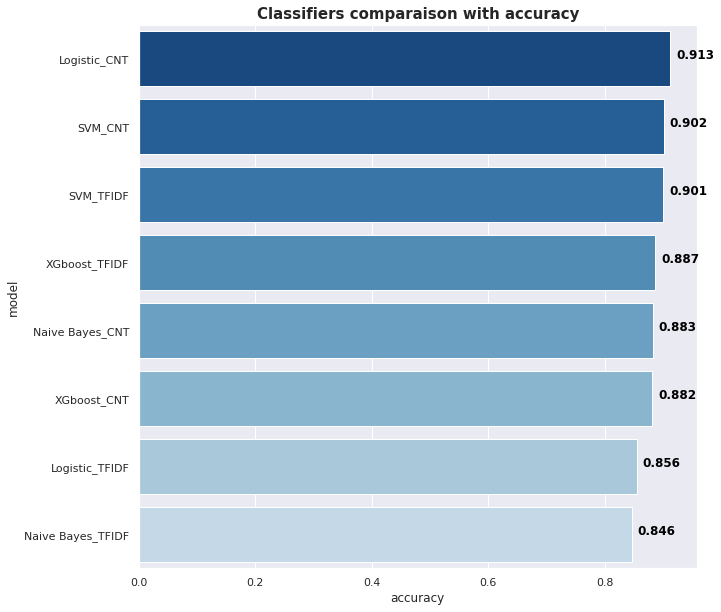

In [103]:
model_y = accuracy_list['model']
x = accuracy_list['accuracy'].sort_values(ascending=False).values

sns.set(rc={'figure.figsize':(10,10)})

ax = sns.barplot(x=x, y=model_y, palette=sns.color_palette("Blues_r",n_colors=10))
ax.set_title('Classifiers comparaison with accuracy', fontsize=15, fontweight="bold")
ax.set(xlabel='accuracy')

for i, v in enumerate(x):
  ax.text(v+0.01, i, str(round(v, 3)), color='black', fontweight='bold')


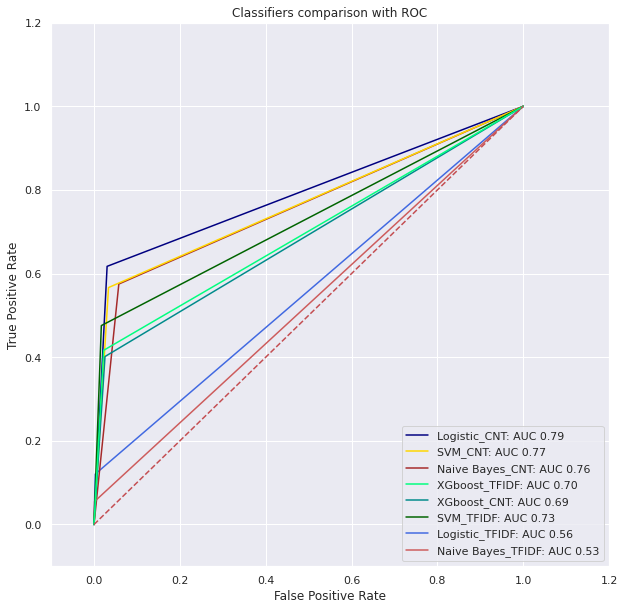

In [104]:
# ROC CURVE

colors_1 = ['navy', 'royalblue', 'brown', 'indianred', 'gold', 'darkgreen', 'darkcyan', 'springgreen']

cmp_i = 0
for model, predicted in prediction.items():
    if model in ('Logistic_CNT', 'Logistic_TFIDF', 'Naive Bayes_CNT','Naive Bayes_TFIDF','SVM_CNT','SVM_TFIDF', 'XGboost_CNT', 'XGboost_TFIDF'):
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predicted)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        plt.plot(false_positive_rate, true_positive_rate, colors_1[cmp_i], label='%s: AUC %0.2f'% (model,roc_auc))
        cmp_i += 1


#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
# #specify order of items in legend
order = [0, 4, 2, 7, 6, 5, 1, 3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower right') 

plt.title('Classifiers comparison with ROC')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.rc('figure', figsize=(12, 8))
plt.show()

In [105]:
# real samples from twitter 
sample_tweets = list() 
sample_tweets.append("Hey @united I was flying from Barcelona to Philadelphia and connecting in Newark NJ. Your customer service rep never submitted my transfer flight from Newark to Philadelphia and they said I have to pay for the connection now. Can you help? #unitedairlinesfails")
sample_tweets.append("Well @united delayed my flight again so I’m stuck in DC tonight. Prob get some pasta in Georgetown and look at JFK’s house lol.")
sample_tweets.append("But I *will* thank @united for being so efficient and having the nicest staff on the phone and IRL! They literally saved this trip 🙏🏻")
sample_tweets.append("@united @Unltedairlanes Bravo to the crew on UA 690 keeping us safe as we experienced a severe wind sheer on final at SeaTac! At Paine Field now getting some fuel to try it again. Keeping us safe and informed shows your commitment to safety and as a 1K it’s appreciated.Thank you!")
sample_tweets = pd.Series(np.array(sample_tweets))

In [106]:
ctv_X, ctv_sample, ctv = countVec(X, sample_tweets)

log = LogisticRegression(C=1.0)
log_result = log.fit(ctv_X, y)

features = ctv.get_feature_names()
feature_coefs = pd.DataFrame(
    data = list(zip(features, log_result.coef_[0])),
    columns = ['word', 'coefficient'])

feature_coefs = feature_coefs.sort_values(['coefficient', 'word'], ascending = [0, 1])
print('-Top 20 positive-')
print(feature_coefs.head(20).to_string(index=False))
print('')
print('-Top 20 negative-')        
print(feature_coefs.tail(20).to_string(index=False)) 
print('')
positive_20 = feature_coefs.head(20)
positive_20.to_excel('positive_20.xlsx', index=False)  
negative_20 = feature_coefs.tail(20)
negative_20.to_excel('negative_20.xlsx', index=False)  

-Top 20 positive-
       word  coefficient
      thank     3.331254
    awesome     3.082594
     thanks     2.892302
  excellent     2.869347
      kudos     2.661158
      great     2.638053
    amazing     2.540848
  wonderful     2.287199
       thnx     2.250134
        thx     2.247384
       best     2.169416
 appreciate     2.159325
exceptional     2.138607
       love     2.021597
    excited     1.970132
    worries     1.953309
       rock     1.903171
   thankful     1.882430
      loved     1.882393
       cool     1.769159

-Top 20 negative-
        word  coefficient
      saying    -1.318166
        fare    -1.321431
      option    -1.329286
    stranded    -1.334792
    solution    -1.343377
        hour    -1.343913
      policy    -1.345470
     website    -1.346776
    feedback    -1.464355
         pay    -1.489147
        rate    -1.492230
disappointed    -1.502137
         hrs    -1.516765
        hold    -1.517682
        paid    -1.566867
     ruining    -1.570

In [107]:
log = LogisticRegression(C=1.0) 
# sample_tweets
ctv_X, ctv_sample, ctv = countVec(X, sample_tweets)
log_result = log.fit(ctv_X, y)
result = log.predict(ctv_sample)
sentiment = {0: "negative", 1: "positive"}
result_list = []
for r in result: 
  result_list.append(sentiment[int(r)])
print("sample tweet sentiments: ", result_list)

sample tweet sentiments:  ['negative', 'negative', 'positive', 'positive']


#Keyword analysis

In [108]:
def tagged_document(list_of_list_of_words):
   for i, list_of_words in enumerate(list_of_list_of_words):
      yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

tokenized_doc = df['clean_text'].apply(lambda x : x.replace(', ', ' ').split())

data_for_training = list(tagged_document(tokenized_doc))
doc2vec = gensim.models.doc2vec.Doc2Vec(vector_size=64, min_count=2, epochs=30)
doc2vec.build_vocab(data_for_training)
doc2vec.train(data_for_training, total_examples=doc2vec.corpus_count, epochs=doc2vec.epochs)

In [109]:
rude_similar = pd.DataFrame(doc2vec.wv.most_similar("rude", topn=10))
rude_similar

,0,1
0,helpful,0.804363
1,unhelpful,0.798863
2,pleasant,0.779050
3,employees,0.769384
4,incredibly,0.717691
5,attitude,0.715188
6,tisk,0.711277
7,staff,0.697971
8,employee,0.690924
9,friendly,0.690172


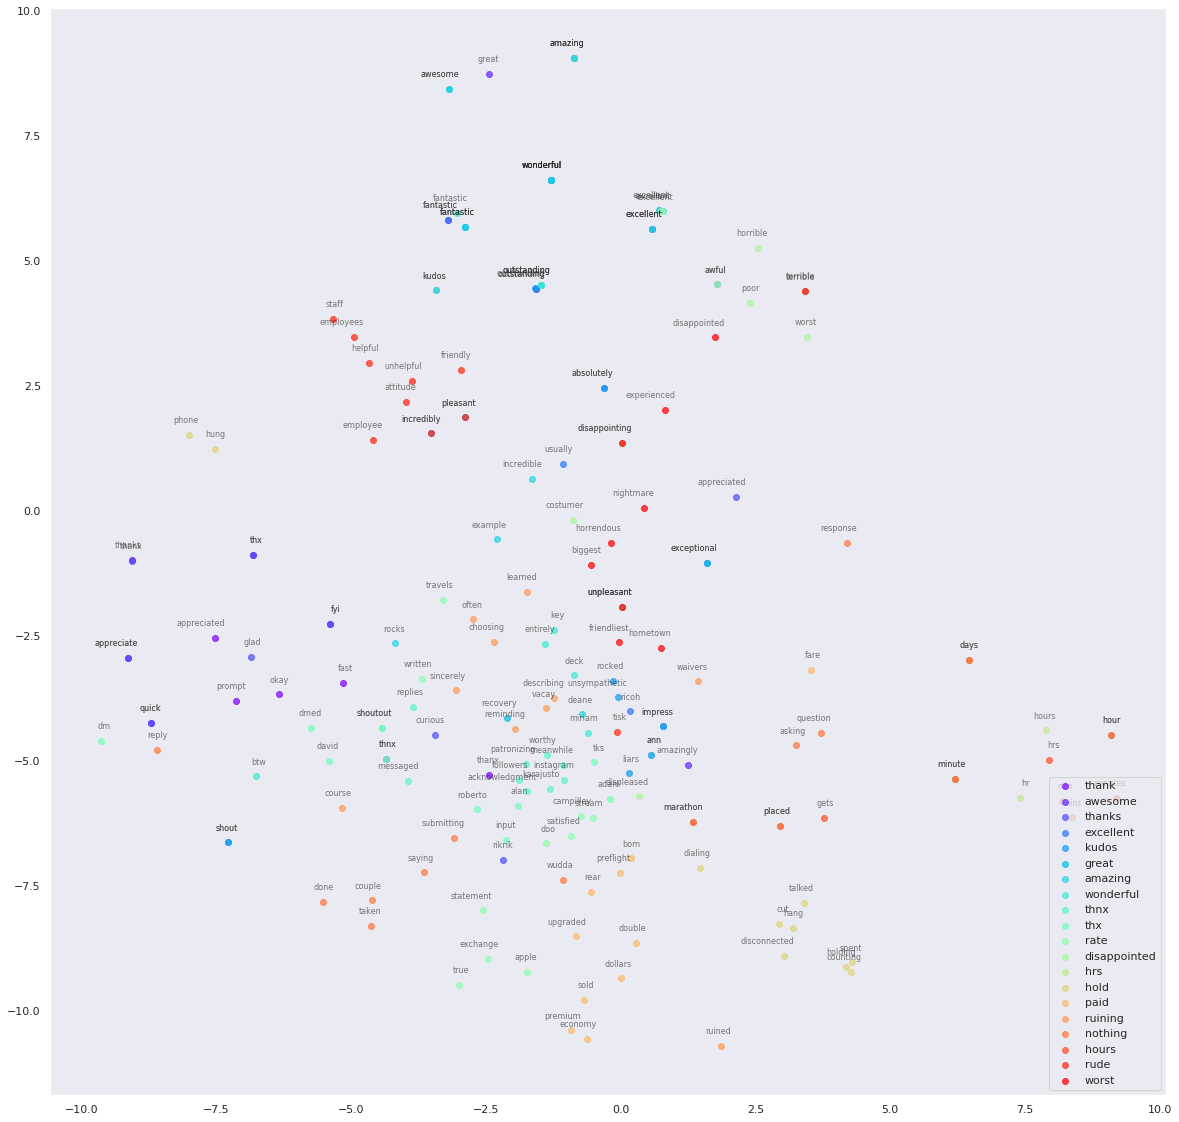

In [110]:
# doc2vec vector  

top10_pos = feature_coefs.head(10)['word'].tolist()
top10_neg = feature_coefs.tail(10)['word'].tolist()
keys = top10_pos + top10_neg
        
embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in doc2vec.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(doc2vec[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

tsne_model_en_2d = TSNE(perplexity=50, n_components=2, init='pca', n_iter=7000, random_state=32)
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(20, 20))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=color.reshape(1,-1), alpha=a, label=label)
        for i, word in enumerate(words):
            ann = '   {}\n'.format(word)
            plt.annotate(word, alpha=0.6, xy=(x[i], y[i]), xytext=(10, 10), 
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(False)
    plt.savefig("cluster.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words(keys, embeddings_en_2d, word_clusters)